In [4]:
from api import M2M
import os,gc
from glob import glob
from dotenv import load_dotenv
import geojson
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import  mapping, Polygon, MultiPolygon, LineString, MultiLineString
from shapely.ops import unary_union, linemerge, polygonize
from osgeo import gdal, osr
gdal.UseExceptions()
import rasterio as rio
import matplotlib.pyplot as plt
from tqdm import tqdm

Matplotlib is building the font cache; this may take a moment.


In [17]:
def get_geojson_boundary(path: str) -> dict:
    '''
    get boundary of a shapefile or geojson, returned as a single geojson features
    ''' 
    gdf = gpd.read_file(path)
    gdf = gdf.to_crs(epsg=4326)
    combined_geometry = unary_union(gdf.geometry)
    if isinstance(combined_geometry, LineString):
        boundary_polygon = Polygon(combined_geometry)
    elif isinstance(combined_geometry, MultiLineString):
        merged = linemerge(boundary) 
        polygons = list(polygonize(merged))
        boundary_polygon = MultiPolygon(polygons)
    else:
        boundary = combined_geometry.boundary
        if isinstance(boundary, MultiLineString):
            merged = linemerge(boundary)
            polygons = list(polygonize(merged))
            boundary_polygon = MultiPolygon(polygons)
        elif isinstance(boundary, LineString):
            boundary_polygon = Polygon(boundary)
        else:
            # I'm really not sure why it would ever come to this cell, but just in case
            print(f'{path} is weird. it didnt work')
            return
    geojson = mapping(boundary_polygon)
    return geojson

### Create M2M object

In [7]:
load_dotenv('.env')
username = os.environ['username']
token = os.environ['token']
m2m = M2M(username=username, token=token)

### Locally Install Bandfiles

specify filters as desired in the cell below

In [8]:
geojson_path = './utils/sierra_nevada_boundary.geojson'
start_date = '20-08-01'
end_date = '20-08-31'
max_cloud_cover = 10
max_results = 10000
get_earliest = True # switch to `False` if desiring latest

The cell below will gather scenes that fall between `startDate` and `endDate` contain area in the geojson specified by . Raw files will be downloaded to a folder called `ingest`

searching for scenes ... Done
landsat_ot_c2_l2 - 19 hits - 19 returned

    filtering for most recent scenes in date range ... Done
    13 scenes remaining

searching for products ... Done
26 products found

    removing duplicates (not sure why there are duplicates) ... Done
    13 products remaining

selecting band files ...
    13 band files found for B5
    13 band files found for B7

downloading band files...
    downloading B5 files ...
    downloading B7 files ...
Done


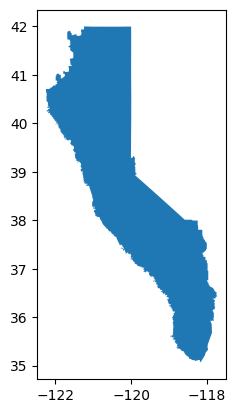

In [19]:
# get scenes
band_names = ['B5', 'B7']
scene_dataset = 'landsat_ot_c2_l2' 
band_dataset = 'landsat_band_files_c2_l2' # raw bands live in a different dataset
geojson_boundary = get_geojson_boundary(geojson_path)


print('searching for scenes ...', end=' ')
params = {
    "datasetName": scene_dataset,
    "startDate": start_date,
    "endDate": end_date,
    'maxCC': max_cloud_cover,
    "maxResults": max_results,
    'geoJsonType': geojson_boundary['type'],
    'geoJsonCoords': geojson_boundary['coordinates']
}
scenes = m2m.searchScenes(**params)
print("Done\n{} - {} hits - {} returned".format(scene_dataset, scenes['totalHits'],scenes['recordsReturned']))

# filter for most recent scenes in given date range
print('\n    filtering for most recent scenes in date range ...', end=' ')
scenes_df = pd.DataFrame(scenes['results'])[['entityId', 'publishDate']]
scenes_df['pathRow'] = scenes_df['entityId'].str[3:9]
grouped_scenes_df = (
    scenes_df
    .sort_values(by='publishDate', ascending=get_earliest)
    .groupby('pathRow')
    .agg(lambda sd: sd.iloc[0])
)
entityIds = list(grouped_scenes_df['entityId'])
print(f'Done\n    {len(entityIds)} scenes remaining')

# search for products
print('\nsearching for products ...', end=' ')
filterOptions = {
    'bulkAvailable': lambda x: x,
    'available': lambda x: x,
    'downloadSystem': lambda x: x=='folder',
    'secondaryDownloads': lambda x: x is not None
    
}
downloadOptions = m2m.downloadOptions(scene_dataset, filterOptions=filterOptions, entityIds=entityIds)
print(f'Done\n{len(downloadOptions)} products found')
print(f'\n    removing duplicates (not sure why there are duplicates) ...', end=' ')
downloadOptions_df = pd.DataFrame(downloadOptions)
downloadOptions_df = downloadOptions_df.groupby('entityId').agg('first')
print(f'Done\n    {downloadOptions_df.shape[0]} products remaining')

# select specific band files
print(f'\nselecting band files ...')
band_files = {}
filtered_downloadOptions = downloadOptions_df.to_dict('records')
for band_name in band_names:
    band_downloads = []
    for product in filtered_downloadOptions:
        for secondaryDownload in product['secondaryDownloads']:
            if band_name in secondaryDownload['displayId']:
                band_downloads.append(secondaryDownload)
    band_files[band_name] = band_downloads
    print(f'    {len(band_downloads)} band files found for {band_name}')


print('\ndownloading band files...')
filterOptions = {
    'available': lambda x: x,
    'downloadName': lambda x: x is not None
}
for band_name in band_names:
    print(f'    downloading {band_name} files ...')
    band_scenes = {'results': band_files[band_name]}
        
    downloadMetaData = m2m.retrieveScenes(
        band_dataset,
        band_scenes, 
        filterOptions=filterOptions
    )
print('Done')


The code from the repository adds `.tar` to the end of every filename. The cell below removes this suffix, while organizing the band files into separate folders.

In [21]:
acq_dir = 'ingest'
data_dir = 'raster_data'
if  not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f'successfully created directory {data_dir}')
else:
    print(f'directory {data_dir} already exists')
for band_name in band_names:
    band_filenames = [band_file['displayId']for band_file in band_files[band_name]]
    band_dir = os.path.join(data_dir, band_name)
    if not os.path.exists(band_dir):
        os.makedirs(band_dir)
        print(f'successfully created directory {band_dir}')
    else:
        print(f'directory {band_dir} already exists')

    for band_filename in band_filenames:
        old_filepath = os.path.join(acq_dir, band_filename+'.tar') # old code adds '.tar' extension to each file
        if os.path.exists(old_filepath):
            new_filepath = os.path.join(band_dir, band_filename)
            os.rename(old_filepath, new_filepath)

if os.path.exists(acq_dir):
    # delete ingest directory
    for filename in os.listdir(acq_dir):
        filepath = os.path.join(acq_dir, filename)
        os.remove(filepath)
    os.rmdir(acq_dir)
    print(f'successfully removed directory {acq_dir}')

successfully created directory raster_data
successfully created directory raster_data/B5
successfully created directory raster_data/B7


### Processing into NBR Data

The cell below defines some more utility functions.

In [22]:
def array_to_raster(array, geoTransform, projection, filename, resample=True):
    if resample:
        np.nan_to_num(array, copy=False, nan=-2, posinf=-2, neginf=-2)
        array = np.round(array * 10000).astype('int16')
        dtype = gdal.GDT_Int16
    else:
        dtype = gdal.GDT_Float32
    pixels_x = array.shape[1]
    pixels_y = array.shape[0]
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(
        filename,
        pixels_x,
        pixels_y,
        1,
        dtype,
        options=['COMPRESS=ZSTD'])
    dataset.SetGeoTransform(geoTransform)
    dataset.SetProjection(projection)
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache() 
    del dataset
    gc.collect()

def reproject(raster_path, crs='EPSG:4326', delete_original=False):
    raster_dir = os.path.dirname(raster_path)
    raster_filename = os.path.basename(raster_path)
    temp_filepath = os.path.join(raster_dir, f'reproj_'+raster_filename)
    in_raster = gdal.Open(raster_path)
    band = in_raster.GetRasterBand(1)
    nodata_value = band.GetNoDataValue()
    if not nodata_value:
        nodata_value=-20000
    gdal.Warp(
        temp_filepath,
        in_raster, 
        dstSRS=crs, 
        dstNodata = nodata_value, 
        srcNodata = nodata_value, 
        options=['-co', 'COMPRESS=ZSTD']
    )
    del in_raster
    if delete_original:
        os.remove(raster_path)
        os.rename(temp_filepath, raster_path)

def get_nbr(band1, band2):
    num = band1 - band2
    denom = band1 + band2
    denom[denom==0] = np.nan
    nbr = num / denom
    return nbr

def write_NBR(band1_filepath, band2_filepath, nbr_filepath):
    ## open B5, B7, and get data
    img =  gdal.Open(band1_filepath)
    band1_data = np.array(img.GetRasterBand(1).ReadAsArray())
    crs = img.GetProjection()
    geoTransform = img.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img.GetProjection())
    img =  gdal.Open(band2_filepath)
    band2_data = np.array(img.GetRasterBand(1).ReadAsArray())
    del img
    ## compute NBR and manage memory
    nbr_data = get_nbr(band1_data.astype('float'), band2_data.astype('float'))
    del band1_data
    del band2_data
    gc.collect()
    ## write to file
    try:
        array_to_raster(nbr_data, geoTransform, crs, nbr_filepath)
        ## delete raw data
    except FileExistsError:
        pass
    except Exception as e:
        print(f"nbr computation failed: {e}")

The cell below computes NBR from the raw band files

In [23]:
data_dir = 'raster_data'
out_band = 'NBR'
band_names = ['B5', 'B7']
filename_stems = [band_filename[:-6]+'{0}.TIF' for band_filename in os.listdir(os.path.join(data_dir, band_names[0]))]
out_band_dir = os.path.join(data_dir, out_band)
if not os.path.exists(out_band_dir):
    os.makedirs(out_band_dir)
for filename_stem in tqdm(filename_stems):
    band_filepaths = [
        os.path.join(data_dir, band_name, filename_stem.format(band_name))
        for band_name in band_names
    ]
    nbr_filepath = os.path.join(out_band_dir, filename_stem.format(out_band))
    if not os.path.exists(nbr_filepath):
        write_NBR(*band_filepaths, nbr_filepath)

  0%|          | 0/13 [00:00<?, ?it/s]/Users/ozanbayiz/get-nbr/.venv/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


The cell below reprojects all values to the desired CRS.

In [24]:
for nbr_filename in tqdm(os.listdir(out_band_dir)):
    nbr_filepath = os.path.join(out_band_dir, nbr_filename)
    reproject(nbr_filepath, crs='EPSG:4326')

100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


The cell below moves all reprojected files to a new directory.

In [25]:
reproj_band_dir = os.path.join(data_dir, 'reproj_'+out_band)
if not os.path.exists(reproj_band_dir):
    os.makedirs(reproj_band_dir)
for reproj_filename in glob(os.path.join(out_band_dir, 'reproj_*.TIF')): # TODO: not glob
    reproj_basename = os.path.basename(reproj_filename)
    os.rename(
        reproj_filename, 
        os.path.join(reproj_band_dir, reproj_basename)
    )

### Tiling and Finishing Touches

The cell below tiles all reprojected files into a single raster

In [28]:
help(gdal.Warp)

Help on function Warp in module osgeo.gdal:

Warp(destNameOrDestDS, srcDSOrSrcDSTab, **kwargs)
    Warp one or several datasets.

    Parameters
    ----------
    destNameOrDestDS:
        Output dataset name or object
    srcDSOrSrcDSTab:
        an array of Dataset objects or filenames, or a Dataset object or a filename
    kwargs:
        options: return of gdal.WarpOptions(), string or array of strings,
        other keywords arguments of gdal.WarpOptions().
        If options is provided as a gdal.WarpOptions() object, other keywords are ignored.



successfully saved output to raster_data/tiled_NBR.TIF


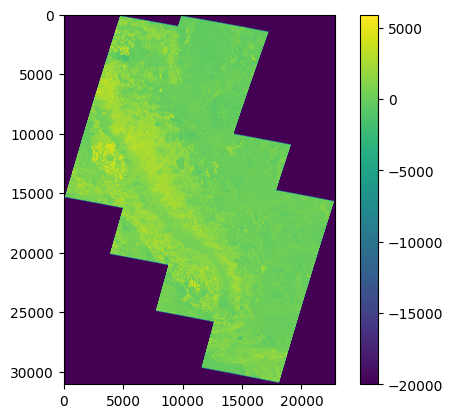

In [34]:
raster_filenames = os.listdir(reproj_band_dir)
raster_filepaths = [os.path.join(reproj_band_dir, raster_filename) for raster_filename in raster_filenames]
tiled_output_name = os.path.join(data_dir, 'tiled_'+out_band+'.TIF')
if not os.path.exists(tiled_output_name):
    gdal.Warp(
        destNameOrDestDS=tiled_output_name,
        srcDSOrSrcDSTab=raster_filepaths,
        format='GTiff',
        resampleAlg='bilinear',
        creationOptions=[
            'COMPRESS=ZSTD', 'TILED=YES'
        ]
    )
    print(f'successfully saved output to {tiled_output_name}')    
else:
    print(f'tiled raster already exists at {tiled_output_name}')

# plot tiled raster
with rio.open(tiled_output_name) as src:
    data = src.read(1)
    plt.imshow(data)
    plt.colorbar();

In [38]:
os.path.splitext(os.path.basename(geojson_path))

('sierra_nevada_boundary', '.geojson')

In [40]:
# This cell was just saves the boundary of the sierra nevada geojson as its own geojson file
geojson_path_split = os.path.splitext(os.path.basename(geojson_path))
geojson_boundary_filename = geojson_path_split[0] + '_boundary' + geojson_path_split[1]
geojson_boundary_filepath = os.path.join('utils', geojson_boundary_filename)

if not os.path.exists(geojson_boundary_filepath):
    with open(geojson_boundary_filepath, 'w') as f:
        geojson.dump(geojson_boundary, f)
    print(f'successfully saved output to {geojson_boundary_filepath}')
else:
    print(f'file already exists at {geojson_boundary_filepath}')

successfully saved output to utils/sierra_nevada_boundary_boundary.geojson


Clip tiled raster to area specified by geojson. It might be better to do this before tiling (?) I'm not sure.

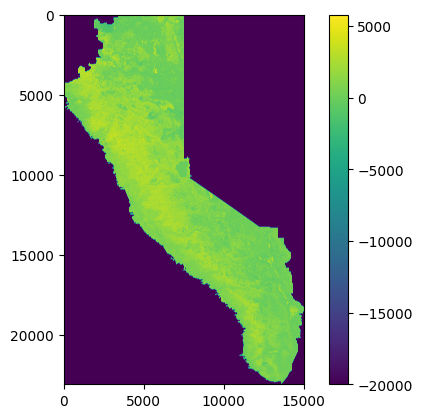

In [42]:
aoi_geojson = geojson_boundary_filepath

clipped_tiled_raster_name = f'clipped_tiled_{out_band}.TIF'
clipped_tiled_raster_filepath = os.path.join(data_dir, clipped_tiled_raster_name)
nodata_value = -20000
gdal.Warp(
    clipped_tiled_raster_filepath,  # Output file
    tiled_output_name,   # Input raster file
    cutlineDSName=aoi_geojson,  # GeoJSON file for the boundary
    cropToCutline=True,  # Crop to the cutline
    dstNodata = nodata_value, 
    srcNodata = nodata_value, 
    creationOptions=[
        'COMPRESS=ZSTD', 'TILED=YES'
    ],
    options=[
        '-multi', '-wo', 'NUM_THREADS=ALL_CPUS'
    ]
)
# plot clipped raster
with rio.open(clipped_tiled_raster_filepath) as src:
    data = src.read(1)
    plt.imshow(data)
    plt.colorbar();

Mask no data, normalize, and plot with a cooler colormap

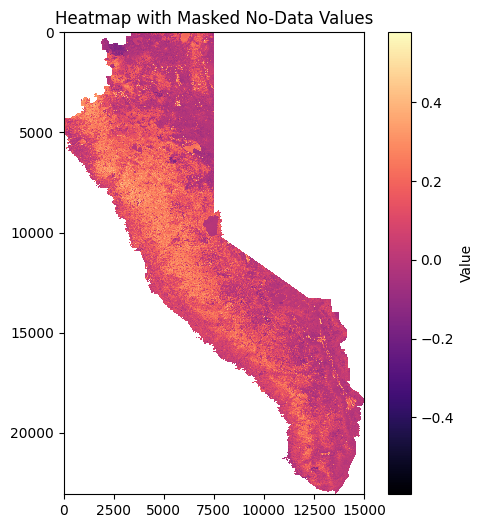

In [44]:
# normalize data and plot
masked_data = np.ma.masked_equal(data, -20000) / 10000
plt.figure(figsize=(6, 6))
plt.imshow(masked_data, cmap='magma', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Heatmap with Masked No-Data Values')
plt.show()

# FIN